# BP-SOM for BERT Fine-tuning on SST-2

This notebook implements BP-SOM (Back-Propagation with Self-Organizing Maps) for BERT fine-tuning on the SST-2 sentiment analysis task.

**BP-SOM** combines supervised backpropagation with unsupervised SOM clustering:
- Standard BP error from task loss
- SOM error from class-specific clustering
- Combined learning: `error = (1-α) * bp_error + α * som_error`

## Setup

Run this notebook on a GPU-enabled environment (Colab, Kaggle, etc.) for faster training.

In [1]:
# Install dependencies
!pip install -q torch transformers datasets numpy scipy scikit-learn matplotlib seaborn tqdm

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer,
    BertModel,
    BertConfig,
    BertPreTrainedModel,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Optional, Tuple, Dict, List

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 1. Self-Organizing Map (SOM) Layer

Implements the core SOM algorithm for BP-SOM.

In [3]:
class SelfOrganizingMap(nn.Module):
    """
    Self-Organizing Map for BP-SOM architecture.
    Optimized with vectorized operations for GPU acceleration.
    """

    def __init__(
        self,
        input_dim: int,
        grid_size: int,
        num_classes: int,
        som_lr_max: float = 0.20,
        som_lr_min: float = 0.05,
        som_context_max: int = 2,
        som_context_min: int = 0,
        reliability_threshold: float = 0.95,
        som_error_weight: float = 0.25,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.som_lr_max = som_lr_max
        self.som_lr_min = som_lr_min
        self.som_context_max = som_context_max
        self.som_context_min = som_context_min
        self.reliability_threshold = reliability_threshold
        self.som_error_weight = som_error_weight

        # SOM grid storage
        self.register_buffer(
            'som_vectors',
            torch.rand(grid_size, grid_size, input_dim) * 0.5 + 0.5
        )
        self.register_buffer(
            'cell_class_counts',
            torch.zeros(grid_size, grid_size, num_classes + 1, dtype=torch.long)
        )
        self.register_buffer(
            'cell_labels',
            torch.zeros(grid_size, grid_size, dtype=torch.long)
        )
        self.register_buffer(
            'cell_reliability',
            torch.zeros(grid_size, grid_size, dtype=torch.float)
        )

        self.total_distance = 0.0
        self.som_usage_count = 0
        self.total_examples = 0

    def get_distance_matrix(self, x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        """
        Compute squared Euclidean distance matrix between batch x and vectors w.
        x: (B, D), w: (N, D) -> returns (B, N)
        """
        x_norm = (x**2).sum(1).view(-1, 1)
        w_norm = (w**2).sum(1).view(1, -1)
        dist = x_norm + w_norm - 2.0 * torch.mm(x, w.t())
        return torch.clamp(dist, 0.0, None)

    def update_som_network_batch(
        self,
        activations: torch.Tensor,
        bmu_indices: torch.Tensor,
        som_lr: float,
        som_context: int
    ):
        """Update SOM prototypes using batch neighborhood learning."""
        B = activations.size(0)
        G = self.grid_size

        # Convert indices to coordinates
        bmu_x = bmu_indices // G
        bmu_y = bmu_indices % G

        # Create coordinate grid (G, G)
        y_grid, x_grid = torch.meshgrid(
            torch.arange(G, device=activations.device),
            torch.arange(G, device=activations.device),
            indexing='ij'
        )

        # Compute Chebyshev distances for all grid cells to all BMUs
        # Expand to (B, G, G)
        dist_x = torch.abs(x_grid.unsqueeze(0) - bmu_x.view(B, 1, 1))
        dist_y = torch.abs(y_grid.unsqueeze(0) - bmu_y.view(B, 1, 1))
        dist_chebyshev = torch.max(dist_x, dist_y)

        # Compute update powers
        mask = (dist_chebyshev <= som_context).float()
        powers = som_lr / (2.0 ** dist_chebyshev)
        powers = powers * mask # (B, G, G)

        # Accumulate updates: sum_k (p_k * (x_k - w))
        # W_new = W_old + sum_k(p_k * x_k) - W_old * sum_k(p_k)

        denom = powers.sum(dim=0).unsqueeze(-1) # (G, G, 1)

        powers_flat = powers.view(B, -1) # (B, G*G)
        num_flat = torch.matmul(powers_flat.t(), activations) # (G*G, B) x (B, D) -> (G*G, D)
        numerator = num_flat.view(G, G, -1)

        self.som_vectors += (numerator - self.som_vectors * denom)

    def forward(
        self,
        activations: torch.Tensor,
        labels: Optional[torch.Tensor] = None,
        epoch: int = 0,
        max_epochs: int = 100,
        training: bool = True
    ) -> Tuple[Optional[torch.Tensor], dict]:
        """Process activations through SOM using vectorized operations."""
        batch_size = activations.size(0)

        # Compute current SOM parameters
        progress = (max_epochs - epoch) / max_epochs if max_epochs > 0 else 0
        progress = max(0, min(1, progress))

        som_context = self.som_context_min + int(
            (progress ** 4) * (self.som_context_max - self.som_context_min)
        )
        som_lr = self.som_lr_min + (progress ** 1) * (self.som_lr_max - self.som_lr_min)

        # Flatten SOM vectors for distance computation: (G*G, D)
        flat_som = self.som_vectors.view(-1, self.input_dim)

        # 1. Compute Distances and Global BMUs
        dists = self.get_distance_matrix(activations, flat_som) # (B, G*G)
        min_dists, bmu_indices = torch.min(dists, dim=1) # (B,)

        # Statistics
        total_dist = torch.sqrt(min_dists).sum().item()
        som_used_count = 0
        som_errors = None

        if training and labels is not None:
            # 2. Compute Class-Specific BMUs and Errors
            # Mask distances where cell_label != label
            flat_labels = self.cell_labels.view(-1)
            # (B, G*G) mask
            label_mask = (flat_labels.unsqueeze(0) != labels.unsqueeze(1))

            class_dists = dists.clone()
            class_dists[label_mask] = float('inf')

            _, class_bmu_indices = torch.min(class_dists, dim=1)

            # Get prototypes and reliability for class BMUs
            class_bmu_vectors = flat_som[class_bmu_indices] # (B, D)
            flat_reliability = self.cell_reliability.view(-1)
            reliabilities = flat_reliability[class_bmu_indices] / 100.0 # (B,)

            # Compute SOM errors
            # valid if reliability >= threshold
            valid_mask = (reliabilities >= self.reliability_threshold).float().unsqueeze(1)
            som_errors = 0.01 * reliabilities.unsqueeze(1) * (class_bmu_vectors - activations)
            som_errors = som_errors * valid_mask

            som_used_count = (reliabilities >= self.reliability_threshold).sum().item()

            # 3. Update SOM Network
            if min_dists.mean() > 1e-4:
                self.update_som_network_batch(activations, bmu_indices, som_lr, som_context)

        self.total_distance += total_dist
        self.som_usage_count += som_used_count
        self.total_examples += batch_size

        stats = {
            'som_lr': som_lr,
            'som_context': som_context,
            'avg_distance': total_dist / batch_size if batch_size > 0 else 0,
            'som_usage_pct': (som_used_count / batch_size * 100) if batch_size > 0 else 0,
        }

        return som_errors, stats

    def update_cell_labels(self, activations: torch.Tensor, labels: torch.Tensor):
        """Update SOM cell class labels using batched processing."""
        self.cell_class_counts.zero_()

        flat_som = self.som_vectors.view(-1, self.input_dim)
        batch_size = 1024 # Process in chunks to save memory

        with torch.no_grad():
            for i in range(0, activations.size(0), batch_size):
                batch_act = activations[i:i+batch_size]
                batch_lbl = labels[i:i+batch_size]

                dists = self.get_distance_matrix(batch_act, flat_som)
                _, bmu_indices = torch.min(dists, dim=1)

                bmu_x = bmu_indices // self.grid_size
                bmu_y = bmu_indices % self.grid_size

                # Accumulate counts
                for j, label in enumerate(batch_lbl):
                    self.cell_class_counts[bmu_x[j], bmu_y[j], label] += 1

        # Update labels and reliability
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                counts = self.cell_class_counts[x, y]
                total = counts.sum().item()

                if total > 0:
                    max_count, max_class = counts.max(0)
                    self.cell_labels[x, y] = max_class
                    self.cell_reliability[x, y] = (max_count.float() / total) * 100
                else:
                    self.cell_labels[x, y] = 0
                    self.cell_reliability[x, y] = 0

    def reset_statistics(self):
        """Reset epoch statistics."""
        self.total_distance = 0.0
        self.som_usage_count = 0
        self.total_examples = 0

    def get_statistics(self) -> dict:
        """Get accumulated statistics."""
        return {
            'avg_distance': self.total_distance / max(1, self.total_examples),
            'som_usage_pct': (self.som_usage_count / max(1, self.total_examples)) * 100,
            'total_examples': self.total_examples,
        }

print("✓ Vectorized SOM Layer defined")

✓ Vectorized SOM Layer defined


## 2. BP-SOM BERT Model

Integrates BERT with BP-SOM hidden layer.

In [4]:
class BPSOMHiddenLayer(nn.Module):
    """Hidden layer with attached SOM for BP-SOM learning."""

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_classes: int,
        dropout: float = 0.1,
        som_grid_size: int = 20,
        som_lr_max: float = 0.20,
        som_lr_min: float = 0.05,
        som_context_max: int = 2,
        som_context_min: int = 0,
        reliability_threshold: float = 0.95,
        som_error_weight: float = 0.25,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.weight = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.1)
        self.bias = nn.Parameter(torch.zeros(hidden_dim))
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

        self.som = SelfOrganizingMap(
            input_dim=hidden_dim,
            grid_size=som_grid_size,
            num_classes=num_classes,
            som_lr_max=som_lr_max,
            som_lr_min=som_lr_min,
            som_context_max=som_context_max,
            som_context_min=som_context_min,
            reliability_threshold=reliability_threshold,
            som_error_weight=som_error_weight,
        )

        self.som_error_weight = som_error_weight

        self.register_buffer('activation_sum', torch.zeros(hidden_dim))
        self.register_buffer('activation_sum_sq', torch.zeros(hidden_dim))
        self.register_buffer('activation_count', torch.zeros(1))

    def forward(
        self,
        x: torch.Tensor,
        labels: Optional[torch.Tensor] = None,
        epoch: int = 0,
        max_epochs: int = 100,
        training: bool = True
    ) -> Tuple[torch.Tensor, dict]:
        """Forward pass with SOM processing."""
        z = torch.nn.functional.linear(x, self.weight, self.bias)
        activations = self.activation(z)

        if training:
            with torch.no_grad():
                self.activation_sum += activations.sum(dim=0)
                self.activation_sum_sq += (activations ** 2).sum(dim=0)
                self.activation_count += activations.size(0)

        som_errors, som_stats = self.som.forward(
            activations,
            labels=labels,
            epoch=epoch,
            max_epochs=max_epochs,
            training=training
        )

        if training and labels is not None and som_errors is not None:
            def som_gradient_hook(grad):
                bp_weight = 1.0 - self.som_error_weight
                combined_grad = bp_weight * grad + self.som_error_weight * som_errors
                return combined_grad

            activations.register_hook(som_gradient_hook)

        activations = self.dropout(activations)
        return activations, som_stats

    def get_activation_statistics(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get mean and std of activations."""
        if self.activation_count > 0:
            mean = self.activation_sum / self.activation_count
            variance = (self.activation_sum_sq / self.activation_count) - (mean ** 2)
            std = torch.sqrt(torch.clamp(variance, min=0))
        else:
            mean = torch.zeros_like(self.activation_sum)
            std = torch.zeros_like(self.activation_sum)
        return mean, std

    def reset_activation_statistics(self):
        """Reset activation tracking."""
        self.activation_sum.zero_()
        self.activation_sum_sq.zero_()
        self.activation_count.zero_()


class BPSOMBertForSequenceClassification(BertPreTrainedModel):
    """BERT model with BP-SOM hidden layer for sequence classification."""

    def __init__(self, config, bpsom_config=None):
        super().__init__(config)

        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)

        if bpsom_config is None:
            bpsom_config = {
                'hidden_size': 128,
                'dropout': 0.1,
                'som_grid_size': 20,
                'som_lr_max': 0.20,
                'som_lr_min': 0.05,
                'som_context_max': 2,
                'som_context_min': 0,
                'reliability_threshold': 0.95,
                'som_error_weight': 0.25,
            }

        self.bpsom_hidden = BPSOMHiddenLayer(
            input_dim=config.hidden_size,
            hidden_dim=bpsom_config.get('hidden_size', 128),
            num_classes=config.num_labels,
            dropout=bpsom_config.get('dropout', 0.1),
            som_grid_size=bpsom_config.get('som_grid_size', 20),
            som_lr_max=bpsom_config.get('som_lr_max', 0.20),
            som_lr_min=bpsom_config.get('som_lr_min', 0.05),
            som_context_max=bpsom_config.get('som_context_max', 2),
            som_context_min=bpsom_config.get('som_context_min', 0),
            reliability_threshold=bpsom_config.get('reliability_threshold', 0.95),
            som_error_weight=bpsom_config.get('som_error_weight', 0.25),
        )

        self.classifier = nn.Linear(bpsom_config.get('hidden_size', 128), config.num_labels)

        self.post_init()

        self.current_epoch = 0
        self.max_epochs = 100

    def set_epoch(self, epoch: int, max_epochs: int):
        """Set current epoch for SOM parameter scheduling."""
        self.current_epoch = epoch
        self.max_epochs = max_epochs

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> SequenceClassifierOutput:
        """Forward pass through BERT + BP-SOM + Classifier."""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        cls_output = outputs.last_hidden_state[:, 0, :]

        hidden_output, som_stats = self.bpsom_hidden(
            cls_output,
            labels=labels,
            epoch=self.current_epoch,
            max_epochs=self.max_epochs,
            training=self.training
        )

        logits = self.classifier(hidden_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def update_som_labels(self, dataloader, device):
        """Update SOM cell labels based on training data."""
        all_activations = []
        all_labels = []

        self.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Updating SOM labels"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self.bert(input_ids, attention_mask=attention_mask, return_dict=True)
                cls_output = outputs.last_hidden_state[:, 0, :]

                z = torch.nn.functional.linear(cls_output, self.bpsom_hidden.weight, self.bpsom_hidden.bias)
                activations = self.bpsom_hidden.activation(z)

                # Keep on device
                all_activations.append(activations)
                all_labels.append(labels)

        all_activations = torch.cat(all_activations, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        self.bpsom_hidden.som.update_cell_labels(all_activations, all_labels)
        self.train()

## 3. Data Loading

Load SST-2 dataset from HuggingFace.

In [5]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load SST-2 dataset
print("Loading SST-2 dataset...")
dataset = load_dataset('glue', 'sst2')

print(f"Train examples: {len(dataset['train'])}")
print(f"Validation examples: {len(dataset['validation'])}")
print(f"Test examples: {len(dataset['test'])}")

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=128)

print("\nTokenizing...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare dataloaders
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch])
    }

batch_size = 32

train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

eval_dataloader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

print("\n✓ Data loaded and prepared")

Loading SST-2 dataset...
Train examples: 67349
Validation examples: 872
Test examples: 1821

Tokenizing...

✓ Data loaded and prepared


## 4. Training Functions

In [6]:
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch, max_epochs):
    """Train for one epoch."""
    model.train()
    model.set_epoch(epoch, max_epochs)

    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{correct/total*100:.2f}%"
        })

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': correct / total * 100
    }


def eval_epoch(model, dataloader, device, desc="Eval"):
    """Evaluate model."""
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': correct / total * 100
    }

print("✓ Training functions defined")

✓ Training functions defined


## 5. Visualization Functions

In [7]:
def plot_som_visualization(model, class_names=['negative', 'positive']):
    """Plot SOM cell labels and reliability."""
    som = model.bpsom_hidden.som
    labels = som.cell_labels.cpu().numpy()
    reliability = som.cell_reliability.cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Labels
    sns.heatmap(
        labels,
        annot=True,
        fmt='d',
        cmap='tab20',
        square=True,
        cbar_kws={'label': 'Class'},
        ax=axes[0]
    )
    axes[0].set_title('SOM Cell Labels', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # Reliability
    sns.heatmap(
        reliability,
        annot=True,
        fmt='.0f',
        cmap='YlOrRd',
        vmin=0,
        vmax=100,
        square=True,
        cbar_kws={'label': 'Reliability (%)'},
        ax=axes[1]
    )
    axes[1].set_title('SOM Cell Reliability', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

    plt.tight_layout()
    plt.show()


def plot_training_curves(history):
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train', marker='o')
    axes[0].plot(history['eval_loss'], label='Validation', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_accuracy'], label='Train', marker='o')
    axes[1].plot(history['eval_accuracy'], label='Validation', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_comparison(baseline_history, bpsom_history):
    """Plot comparison between baseline and BP-SOM."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Validation Loss
    axes[0].plot(baseline_history['eval_loss'], label='Baseline BERT', marker='o', linewidth=2)
    axes[0].plot(bpsom_history['eval_loss'], label='BP-SOM BERT', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Loss', fontsize=12)
    axes[0].set_title('Comparison: Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1].plot(baseline_history['eval_accuracy'], label='Baseline BERT', marker='o', linewidth=2)
    axes[1].plot(bpsom_history['eval_accuracy'], label='BP-SOM BERT', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[1].set_title('Comparison: Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


## 6. Train Baseline BERT

First, train a baseline BERT model for comparison.

In [8]:
# Configuration
num_epochs = 3
learning_rate = 2e-5
warmup_steps = 500

print("=" * 80)
print("BASELINE BERT EXPERIMENT")
print("=" * 80)

# Initialize baseline model
baseline_config = BertConfig.from_pretrained('bert-base-uncased')
baseline_config.num_labels = 2

baseline_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=baseline_config
).to(device)

# Add a dummy set_epoch method to the baseline model to satisfy the train_epoch function's expectation.
# The original BertForSequenceClassification does not have this method, but BPSOMBertForSequenceClassification does.
def dummy_set_epoch(self, epoch: int, max_epochs: int):
    pass
baseline_model.set_epoch = dummy_set_epoch.__get__(baseline_model, type(baseline_model))


# Optimizer and scheduler
baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
baseline_scheduler = get_linear_schedule_with_warmup(
    baseline_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training loop
baseline_history = {
    'train_loss': [],
    'train_accuracy': [],
    'eval_loss': [],
    'eval_accuracy': []
}

best_baseline_acc = 0.0

for epoch in range(num_epochs):
    # Train
    train_metrics = train_epoch(
        baseline_model,
        train_dataloader,
        baseline_optimizer,
        baseline_scheduler,
        device,
        epoch,
        num_epochs
    )

    # Evaluate
    eval_metrics = eval_epoch(baseline_model, eval_dataloader, device, "Validation")

    # Log
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.2f}%")
    print(f"  Val   - Loss: {eval_metrics['loss']:.4f}, Acc: {eval_metrics['accuracy']:.2f}%")

    baseline_history['train_loss'].append(train_metrics['loss'])
    baseline_history['train_accuracy'].append(train_metrics['accuracy'])
    baseline_history['eval_loss'].append(eval_metrics['loss'])
    baseline_history['eval_accuracy'].append(eval_metrics['accuracy'])

    if eval_metrics['accuracy'] > best_baseline_acc:
        best_baseline_acc = eval_metrics['accuracy']
        print(f"  ✓ New best validation accuracy!")

    print("-" * 80)

print(f"\nBaseline Training Complete!")
print(f"Best Validation Accuracy: {best_baseline_acc:.2f}%")

BASELINE BERT EXPERIMENT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 28/28 [00:01<00:00, 18.70it/s]



Epoch 1/3:
  Train - Loss: 0.2376, Acc: 89.85%
  Val   - Loss: 0.2057, Acc: 92.20%
  ✓ New best validation accuracy!
--------------------------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.79it/s]



Epoch 2/3:
  Train - Loss: 0.1027, Acc: 96.48%
  Val   - Loss: 0.2265, Acc: 91.63%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.68it/s]


Epoch 3/3:
  Train - Loss: 0.0615, Acc: 97.89%
  Val   - Loss: 0.2419, Acc: 91.86%
--------------------------------------------------------------------------------

Baseline Training Complete!
Best Validation Accuracy: 92.20%


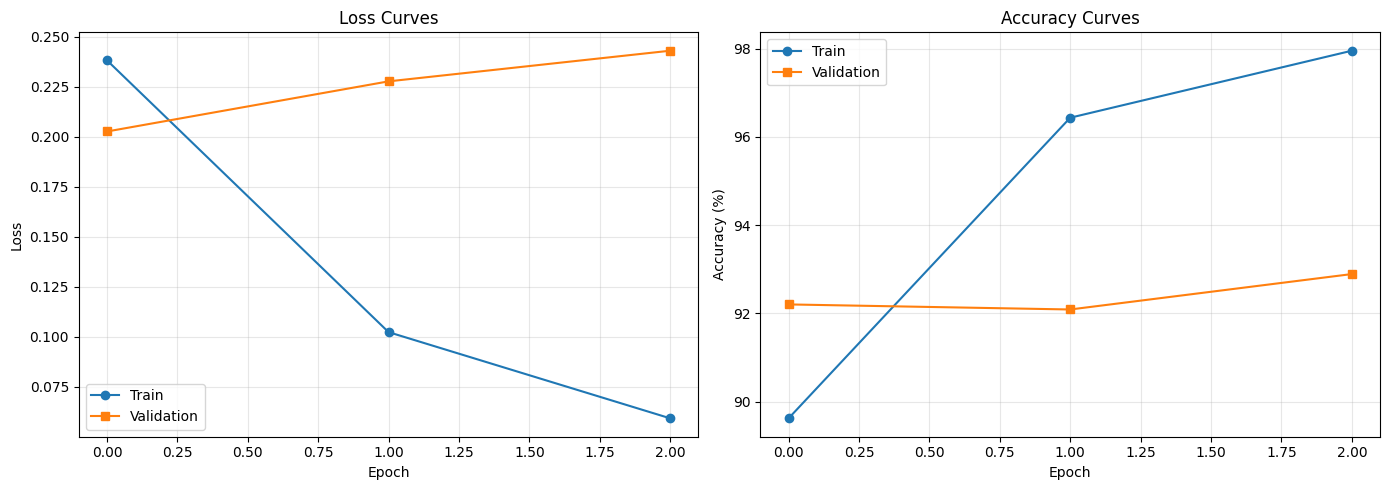

In [ ]:
# Plot baseline results
plot_training_curves(baseline_history)

## 7. Train BP-SOM BERT

Now train the BP-SOM enhanced model.

In [9]:
print("=" * 80)
print("BP-SOM BERT EXPERIMENT")
print("=" * 80)

# Initialize BP-SOM model
bpsom_config = BertConfig.from_pretrained('bert-base-uncased')
bpsom_config.num_labels = 2

bpsom_model_config = {
    'hidden_size': 128,
    'dropout': 0.1,
    'som_grid_size': 20,
    'som_error_weight': 0.25,
    'som_lr_max': 0.20,
    'som_lr_min': 0.05,
    'som_context_max': 2,
    'som_context_min': 0,
    'reliability_threshold': 0.95,
}

bpsom_model = BPSOMBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=bpsom_config,
    bpsom_config=bpsom_model_config
).to(device)

# Optimizer and scheduler
bpsom_optimizer = torch.optim.AdamW(bpsom_model.parameters(), lr=learning_rate)
bpsom_scheduler = get_linear_schedule_with_warmup(
    bpsom_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training loop
bpsom_history = {
    'train_loss': [],
    'train_accuracy': [],
    'eval_loss': [],
    'eval_accuracy': [],
    'som_stats': []
}

best_bpsom_acc = 0.0

for epoch in range(num_epochs):
    # Reset SOM statistics
    bpsom_model.bpsom_hidden.som.reset_statistics()
    bpsom_model.bpsom_hidden.reset_activation_statistics()

    # Train
    train_metrics = train_epoch(
        bpsom_model,
        train_dataloader,
        bpsom_optimizer,
        bpsom_scheduler,
        device,
        epoch,
        num_epochs
    )

    # Update SOM cell labels
    # print("\nUpdating SOM cell labels...")
    bpsom_model.update_som_labels(train_dataloader, device)

    # Get SOM statistics
    som_stats = bpsom_model.bpsom_hidden.som.get_statistics()

    # Evaluate
    eval_metrics = eval_epoch(bpsom_model, eval_dataloader, device, "Validation")

    # Log
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.2f}%, "
          f"SOM Usage: {som_stats['som_usage_pct']:.1f}%")
    print(f"  Val   - Loss: {eval_metrics['loss']:.4f}, Acc: {eval_metrics['accuracy']:.2f}%")

    bpsom_history['train_loss'].append(train_metrics['loss'])
    bpsom_history['train_accuracy'].append(train_metrics['accuracy'])
    bpsom_history['eval_loss'].append(eval_metrics['loss'])
    bpsom_history['eval_accuracy'].append(eval_metrics['accuracy'])
    bpsom_history['som_stats'].append(som_stats)

    if eval_metrics['accuracy'] > best_bpsom_acc:
        best_bpsom_acc = eval_metrics['accuracy']
        print(f"  ✓ New best validation accuracy!")

    print("-" * 80)

print(f"\nBP-SOM Training Complete!")
print(f"Best Validation Accuracy: {best_bpsom_acc:.2f}%")

BP-SOM BERT EXPERIMENT


Some weights of BPSOMBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bpsom_hidden.activation_count', 'bpsom_hidden.activation_sum', 'bpsom_hidden.activation_sum_sq', 'bpsom_hidden.bias', 'bpsom_hidden.som.cell_class_counts', 'bpsom_hidden.som.cell_labels', 'bpsom_hidden.som.cell_reliability', 'bpsom_hidden.som.som_vectors', 'bpsom_hidden.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 [Train]: 100%|██████████| 2105/2105 [05:37<00:00,  6.23it/s, loss=0.1342, acc=88.53%]



Updating SOM cell labels...


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.77it/s]



Epoch 1/3:
  Train - Loss: 0.3103, Acc: 88.53%, SOM Usage: 0.0%
  Val   - Loss: 0.2344, Acc: 91.40%
  ✓ New best validation accuracy!
--------------------------------------------------------------------------------


Epoch 2/3 [Train]: 100%|██████████| 2105/2105 [05:37<00:00,  6.24it/s, loss=0.0387, acc=96.23%]



Updating SOM cell labels...


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.35it/s]



Epoch 2/3:
  Train - Loss: 0.1273, Acc: 96.23%, SOM Usage: 76.6%
  Val   - Loss: 0.2313, Acc: 92.55%
  ✓ New best validation accuracy!
--------------------------------------------------------------------------------


Epoch 3/3 [Train]: 100%|██████████| 2105/2105 [05:37<00:00,  6.24it/s, loss=0.0266, acc=97.71%]



Updating SOM cell labels...


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.32it/s]


Epoch 3/3:
  Train - Loss: 0.0848, Acc: 97.71%, SOM Usage: 92.6%
  Val   - Loss: 0.2167, Acc: 92.78%
  ✓ New best validation accuracy!
--------------------------------------------------------------------------------

BP-SOM Training Complete!
Best Validation Accuracy: 92.78%


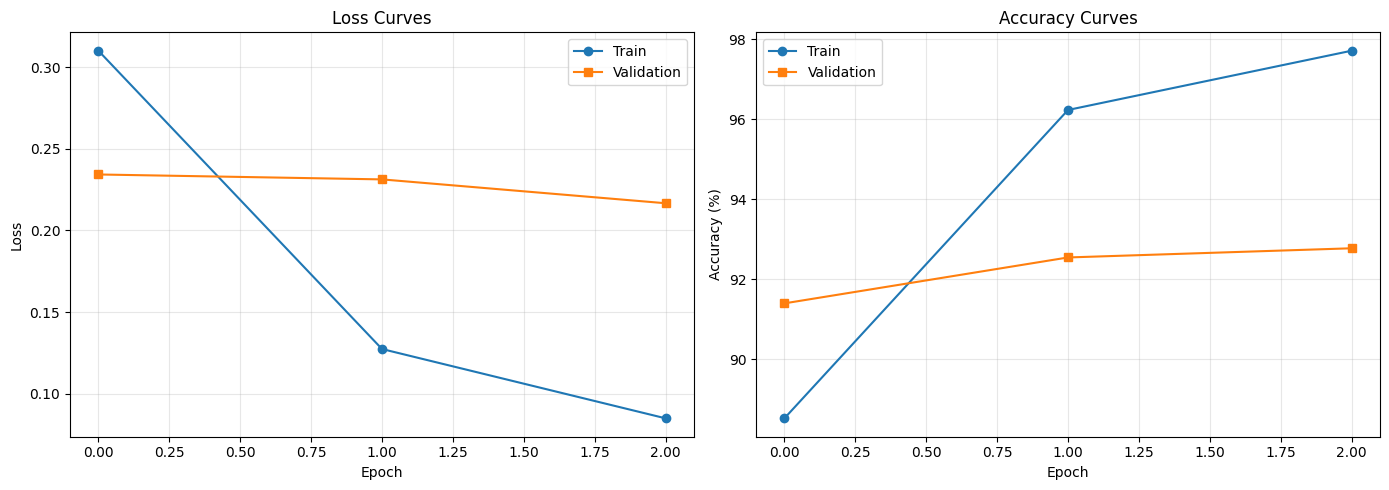

In [10]:
# Plot BP-SOM results
plot_training_curves(bpsom_history)

## 8. Visualize SOM Organization

SOM Organization after Training:


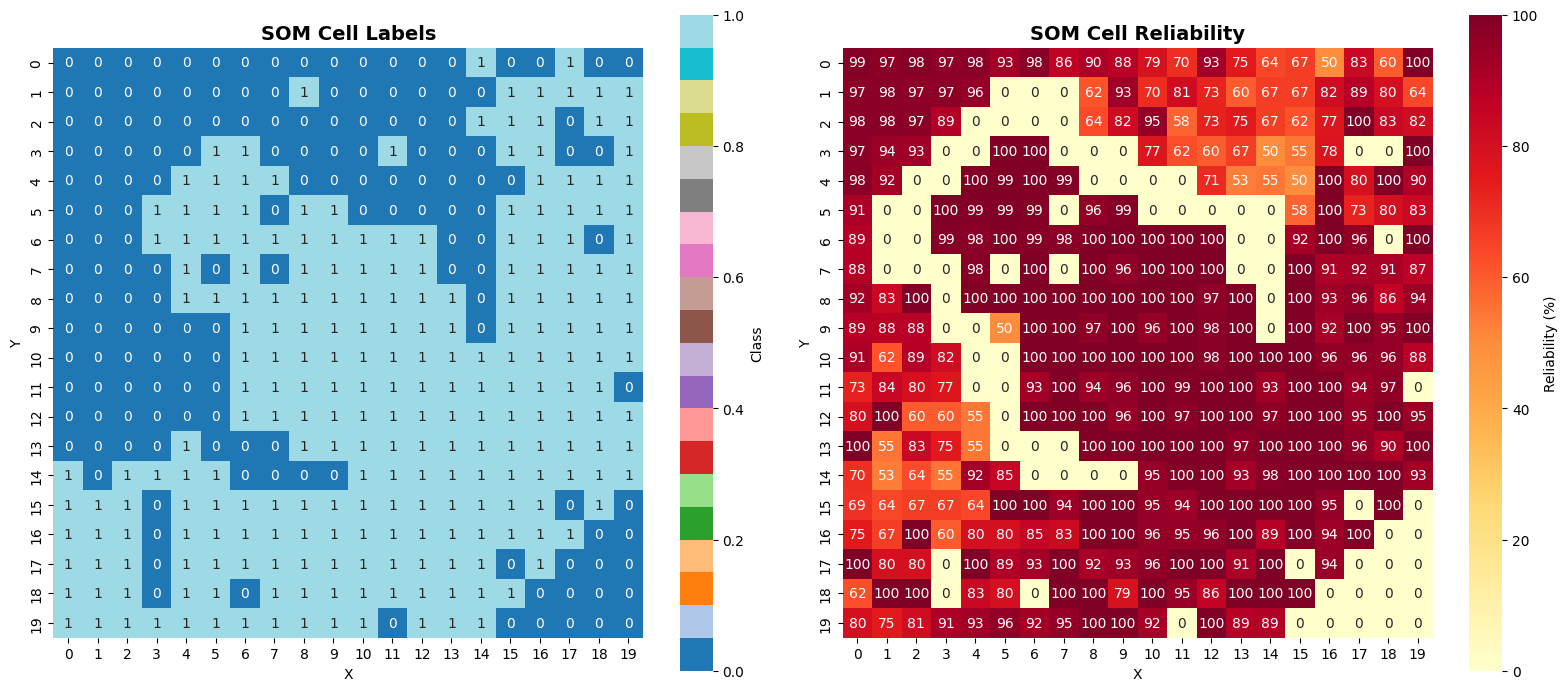

In [11]:
# Visualize final SOM state
print("SOM Organization after Training:")
plot_som_visualization(bpsom_model, class_names=['negative', 'positive'])

## 9. Compare Results

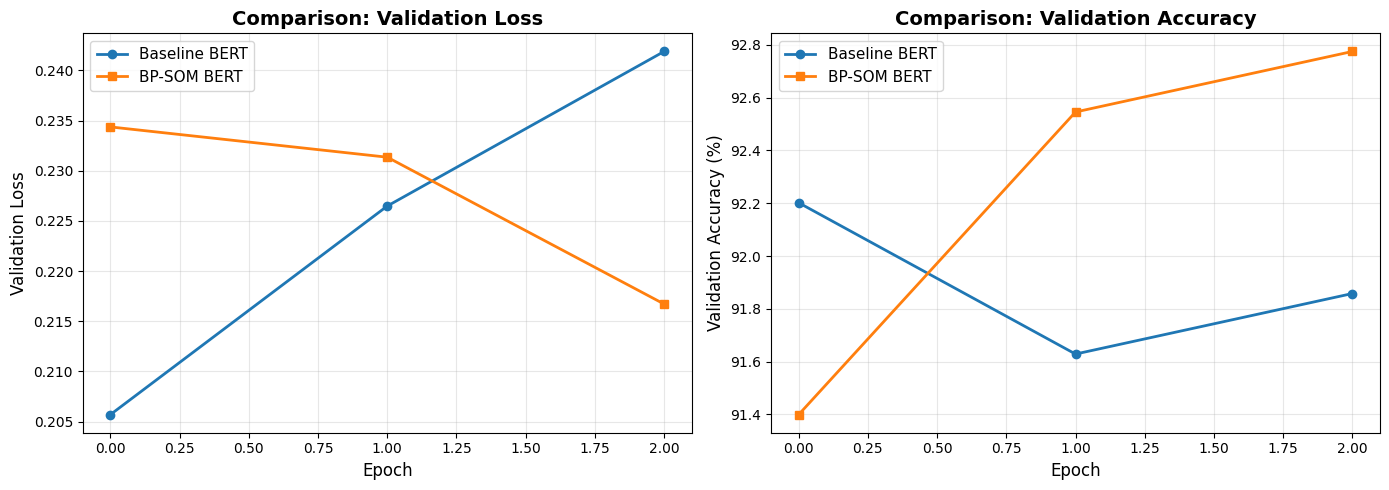


FINAL COMPARISON SUMMARY
Baseline BERT:
  Best Validation Accuracy: 92.20%
  Final Validation Loss: 0.2419

BP-SOM BERT:
  Best Validation Accuracy: 92.78%
  Final Validation Loss: 0.2167
  SOM Usage: 92.6%

Improvement: +0.57% accuracy


In [12]:
# Comparison plot
plot_comparison(baseline_history, bpsom_history)

# Summary statistics
print("\n" + "=" * 80)
print("FINAL COMPARISON SUMMARY")
print("=" * 80)
print(f"Baseline BERT:")
print(f"  Best Validation Accuracy: {max(baseline_history['eval_accuracy']):.2f}%")
print(f"  Final Validation Loss: {baseline_history['eval_loss'][-1]:.4f}")
print()
print(f"BP-SOM BERT:")
print(f"  Best Validation Accuracy: {max(bpsom_history['eval_accuracy']):.2f}%")
print(f"  Final Validation Loss: {bpsom_history['eval_loss'][-1]:.4f}")
print(f"  SOM Usage: {bpsom_history['som_stats'][-1]['som_usage_pct']:.1f}%")
print()

improvement = max(bpsom_history['eval_accuracy']) - max(baseline_history['eval_accuracy'])
print(f"Improvement: {improvement:+.2f}% accuracy")
print("=" * 80)

## 10. Analyze SOM Statistics

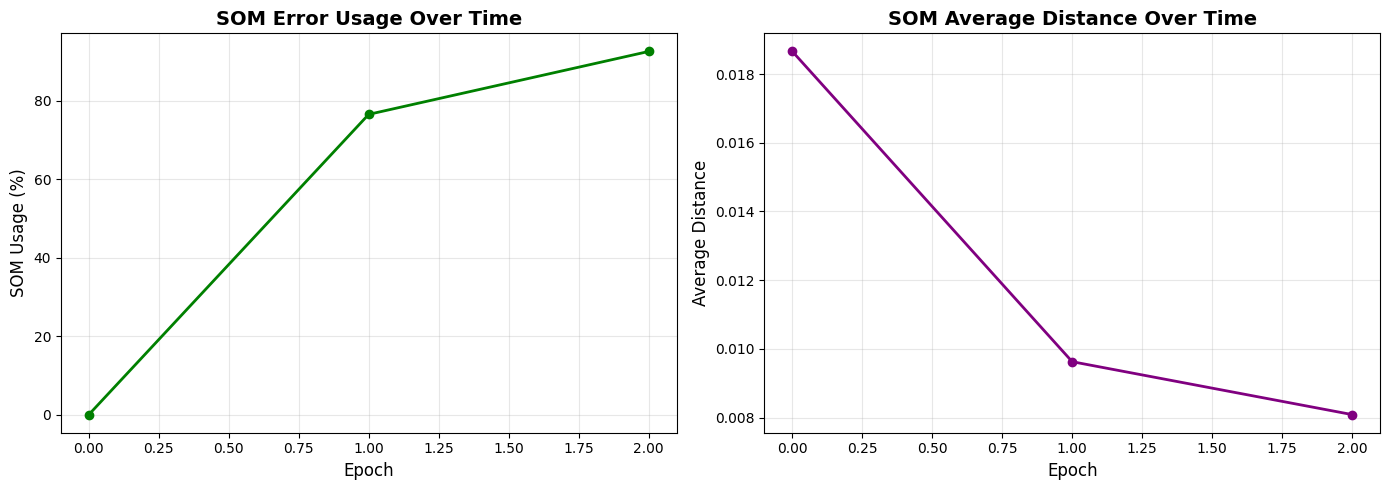


SOM Statistics:
  Final SOM Usage: 92.6%
  Final Average Distance: 0.008
  SOM Grid Size: 20x20


In [13]:
# Plot SOM statistics over epochs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

som_usage = [stat['som_usage_pct'] for stat in bpsom_history['som_stats']]
som_dist = [stat['avg_distance'] for stat in bpsom_history['som_stats']]

axes[0].plot(som_usage, marker='o', color='green', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('SOM Usage (%)', fontsize=12)
axes[0].set_title('SOM Error Usage Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(som_dist, marker='o', color='purple', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Average Distance', fontsize=12)
axes[1].set_title('SOM Average Distance Over Time', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSOM Statistics:")
print(f"  Final SOM Usage: {som_usage[-1]:.1f}%")
print(f"  Final Average Distance: {som_dist[-1]:.3f}")
print(f"  SOM Grid Size: {bpsom_model.bpsom_hidden.som.grid_size}x{bpsom_model.bpsom_hidden.som.grid_size}")

## 11. Unit Pruning

BP-SOM supports dynamic pruning of inactive hidden units based on activation statistics. Units with low activation variance are considered inactive and can be pruned to reduce model complexity while potentially improving generalization.

In [ ]:
class UnitPruner:
    """
    Handles pruning of inactive hidden units in BP-SOM layer.
    Units with low activation variance (std < threshold) are considered
    inactive and can be pruned to reduce model complexity.
    """

    def __init__(
        self,
        prune_threshold: float = 0.02,
        min_units: int = 1,
        enabled: bool = True,
    ):
        self.prune_threshold = prune_threshold
        self.min_units = min_units
        self.enabled = enabled
        self.pruning_history = []

    def identify_prunable_units(
        self,
        mean_activations: torch.Tensor,
        std_activations: torch.Tensor
    ) -> List[int]:
        """Identify units that should be pruned based on activation std."""
        if not self.enabled:
            return []

        hidden_dim = std_activations.size(0)
        prunable_mask = std_activations <= self.prune_threshold
        prunable_indices = torch.where(prunable_mask)[0].tolist()

        # Ensure we don't prune below minimum
        current_units = hidden_dim
        units_to_remove = len(prunable_indices)

        if current_units - units_to_remove < self.min_units:
            max_to_prune = current_units - self.min_units
            if max_to_prune > 0:
                sorted_indices = torch.argsort(std_activations)
                prunable_indices = sorted_indices[:max_to_prune].tolist()
            else:
                prunable_indices = []

        return prunable_indices

    def prune_units(
        self,
        model,
        units_to_prune: List[int],
        mean_activations: torch.Tensor
    ) -> bool:
        """Prune specified units from BP-SOM hidden layer."""
        if not units_to_prune:
            return False

        print(f"  Pruning {len(units_to_prune)} units: {units_to_prune[:10]}{'...' if len(units_to_prune) > 10 else ''}")

        hidden_layer = model.bpsom_hidden
        classifier = model.classifier

        input_dim = hidden_layer.input_dim
        hidden_dim = hidden_layer.hidden_dim
        output_dim = classifier.out_features

        # Create mask for keeping units
        keep_mask = torch.ones(hidden_dim, dtype=torch.bool, device=hidden_layer.weight.device)
        keep_mask[units_to_prune] = False
        keep_indices = torch.where(keep_mask)[0]

        new_hidden_dim = len(keep_indices)

        # 1. Update hidden layer weights
        new_weight = hidden_layer.weight.data[keep_indices, :]
        new_bias = hidden_layer.bias.data[keep_indices]

        # 2. Update classifier weights - absorb pruned units into bias
        old_classifier_weight = classifier.weight.data.clone()
        old_classifier_bias = classifier.bias.data.clone()

        for unit_idx in units_to_prune:
            contribution = mean_activations[unit_idx] * old_classifier_weight[:, unit_idx]
            old_classifier_bias += contribution

        new_classifier_weight = old_classifier_weight[:, keep_indices]

        # 3. Update SOM prototypes
        som = hidden_layer.som
        old_som_vectors = som.som_vectors.data.clone()
        new_som_vectors = old_som_vectors[:, :, keep_indices]

        # 4. Apply updates
        hidden_layer.weight = nn.Parameter(new_weight)
        hidden_layer.bias = nn.Parameter(new_bias)
        hidden_layer.hidden_dim = new_hidden_dim

        hidden_layer.activation_sum = hidden_layer.activation_sum[keep_indices]
        hidden_layer.activation_sum_sq = hidden_layer.activation_sum_sq[keep_indices]

        som.input_dim = new_hidden_dim
        som.som_vectors = som.som_vectors.data[:, :, keep_indices]

        classifier.in_features = new_hidden_dim
        classifier.weight = nn.Parameter(new_classifier_weight)
        classifier.bias = nn.Parameter(old_classifier_bias)

        print(f"  Hidden layer dimension: {hidden_dim} -> {new_hidden_dim}")

        self.pruning_history.append({
            'units_pruned': len(units_to_prune),
            'old_dim': hidden_dim,
            'new_dim': new_hidden_dim,
        })

        return True

    def check_and_prune(self, model, epoch: int) -> bool:
        """Check activation statistics and prune if necessary."""
        if not self.enabled:
            return False

        mean_act, std_act = model.bpsom_hidden.get_activation_statistics()
        units_to_prune = self.identify_prunable_units(mean_act, std_act)

        if units_to_prune:
            print(f"\n  Detected {len(units_to_prune)} inactive units (std < {self.prune_threshold})")
            pruned = self.prune_units(model, units_to_prune, mean_act)
            if pruned:
                model.bpsom_hidden.reset_activation_statistics()
            return pruned
        return False

    def get_pruning_summary(self) -> dict:
        """Get summary of pruning events."""
        if not self.pruning_history:
            return {
                'total_events': 0,
                'total_units_pruned': 0,
                'initial_dim': None,
                'final_dim': None,
            }

        total_pruned = sum(event['units_pruned'] for event in self.pruning_history)
        initial_dim = self.pruning_history[0]['old_dim']
        final_dim = self.pruning_history[-1]['new_dim']

        return {
            'total_events': len(self.pruning_history),
            'total_units_pruned': total_pruned,
            'initial_dim': initial_dim,
            'final_dim': final_dim,
            'reduction_pct': (initial_dim - final_dim) / initial_dim * 100,
        }

print("✓ UnitPruner class defined")

In [ ]:
print("=" * 80)
print("BP-SOM BERT WITH PRUNING EXPERIMENT")
print("=" * 80)

# Initialize BP-SOM model with pruning
bpsom_pruning_config = BertConfig.from_pretrained('bert-base-uncased')
bpsom_pruning_config.num_labels = 2

bpsom_pruning_model_config = {
    'hidden_size': 128,
    'dropout': 0.1,
    'som_grid_size': 20,
    'som_error_weight': 0.25,
    'som_lr_max': 0.20,
    'som_lr_min': 0.05,
    'som_context_max': 2,
    'som_context_min': 0,
    'reliability_threshold': 0.95,
}

bpsom_pruning_model = BPSOMBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=bpsom_pruning_config,
    bpsom_config=bpsom_pruning_model_config
).to(device)

# Initialize pruner
pruner = UnitPruner(prune_threshold=0.02, min_units=16, enabled=True)

# Optimizer and scheduler
bpsom_pruning_optimizer = torch.optim.AdamW(bpsom_pruning_model.parameters(), lr=learning_rate)
bpsom_pruning_scheduler = get_linear_schedule_with_warmup(
    bpsom_pruning_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training loop
bpsom_pruning_history = {
    'train_loss': [],
    'train_accuracy': [],
    'eval_loss': [],
    'eval_accuracy': [],
    'som_stats': [],
    'hidden_dims': []
}

best_bpsom_pruning_acc = 0.0

for epoch in range(num_epochs):
    # Reset SOM statistics
    bpsom_pruning_model.bpsom_hidden.som.reset_statistics()
    bpsom_pruning_model.bpsom_hidden.reset_activation_statistics()
    
    # Record current hidden dimension
    current_dim = bpsom_pruning_model.bpsom_hidden.hidden_dim
    bpsom_pruning_history['hidden_dims'].append(current_dim)

    # Train
    train_metrics = train_epoch(
        bpsom_pruning_model,
        train_dataloader,
        bpsom_pruning_optimizer,
        bpsom_pruning_scheduler,
        device,
        epoch,
        num_epochs
    )

    # Update SOM cell labels
    bpsom_pruning_model.update_som_labels(train_dataloader, device)

    # Get SOM statistics
    som_stats = bpsom_pruning_model.bpsom_hidden.som.get_statistics()

    # Evaluate
    eval_metrics = eval_epoch(bpsom_pruning_model, eval_dataloader, device, "Validation")

    # Log
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.2f}%, "
          f"SOM Usage: {som_stats['som_usage_pct']:.1f}%")
    print(f"  Val   - Loss: {eval_metrics['loss']:.4f}, Acc: {eval_metrics['accuracy']:.2f}%")
    print(f"  Hidden Layer Dimension: {current_dim}")

    bpsom_pruning_history['train_loss'].append(train_metrics['loss'])
    bpsom_pruning_history['train_accuracy'].append(train_metrics['accuracy'])
    bpsom_pruning_history['eval_loss'].append(eval_metrics['loss'])
    bpsom_pruning_history['eval_accuracy'].append(eval_metrics['accuracy'])
    bpsom_pruning_history['som_stats'].append(som_stats)

    if eval_metrics['accuracy'] > best_bpsom_pruning_acc:
        best_bpsom_pruning_acc = eval_metrics['accuracy']
        print(f"  ✓ New best validation accuracy!")

    # Check for pruning after each epoch
    pruner.check_and_prune(bpsom_pruning_model, epoch)
    
    print("-" * 80)

# Record final dimension
bpsom_pruning_history['hidden_dims'].append(bpsom_pruning_model.bpsom_hidden.hidden_dim)

print(f"\nBP-SOM with Pruning Training Complete!")
print(f"Best Validation Accuracy: {best_bpsom_pruning_acc:.2f}%")

# Show pruning summary
pruning_summary = pruner.get_pruning_summary()
print(f"\nPruning Summary:")
print(f"  Total pruning events: {pruning_summary['total_events']}")
print(f"  Total units pruned: {pruning_summary['total_units_pruned']}")
if pruning_summary['initial_dim']:
    print(f"  Hidden dimension: {pruning_summary['initial_dim']} -> {pruning_summary['final_dim']}")
    print(f"  Reduction: {pruning_summary['reduction_pct']:.1f}%")

In [ ]:
# Final comparison including pruning
print("\n" + "=" * 80)
print("FINAL COMPARISON SUMMARY (WITH PRUNING)")
print("=" * 80)
print(f"Baseline BERT:")
print(f"  Best Validation Accuracy: {max(baseline_history['eval_accuracy']):.2f}%")
print()
print(f"BP-SOM BERT:")
print(f"  Best Validation Accuracy: {max(bpsom_history['eval_accuracy']):.2f}%")
print(f"  Hidden dimension: 128")
print()
print(f"BP-SOM BERT + Pruning:")
print(f"  Best Validation Accuracy: {max(bpsom_pruning_history['eval_accuracy']):.2f}%")
print(f"  Final hidden dimension: {bpsom_pruning_model.bpsom_hidden.hidden_dim}")
print()

# Compare all methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation Accuracy comparison
axes[0].plot(baseline_history['eval_accuracy'], label='Baseline BERT', marker='o', linewidth=2)
axes[0].plot(bpsom_history['eval_accuracy'], label='BP-SOM BERT', marker='s', linewidth=2)
axes[0].plot(bpsom_pruning_history['eval_accuracy'], label='BP-SOM + Pruning', marker='^', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Hidden dimension over time
axes[1].plot(bpsom_pruning_history['hidden_dims'][:-1], marker='o', color='red', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Hidden Dimension', fontsize=12)
axes[1].set_title('Hidden Layer Size Over Training', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 80)
bpsom_improvement = max(bpsom_history['eval_accuracy']) - max(baseline_history['eval_accuracy'])
pruning_improvement = max(bpsom_pruning_history['eval_accuracy']) - max(baseline_history['eval_accuracy'])

print(f"BP-SOM vs Baseline:          {bpsom_improvement:+.2f}% accuracy")
print(f"BP-SOM+Pruning vs Baseline:  {pruning_improvement:+.2f}% accuracy")
print("=" * 80)

## 12. Save Models (Optional)

In [ ]:
# Uncomment to save models
# torch.save(baseline_model.state_dict(), 'baseline_bert_sst2.pt')
# torch.save(bpsom_model.state_dict(), 'bpsom_bert_sst2.pt')
# print("✓ Models saved")

## Conclusion

This notebook demonstrates BP-SOM applied to BERT fine-tuning on SST-2:

### Key Observations:

1. **SOM Organization**: The SOM develops class-specific clusters during training
2. **SOM Usage**: The percentage of examples where SOM error is used (reliability >= threshold)
3. **Performance**: Compare baseline vs BP-SOM accuracy

### Next Steps:

- Experiment with different SOM grid sizes
- Adjust SOM error weight (α)
- Try other GLUE tasks (MRPC, CoLA, etc.)
- Analyze learned representations

### References:

- Weijters, A. (1995). The BP-SOM architecture and learning algorithm. *Neural Processing Letters*, 2:6, pp. 13-16.
- Original C implementation: https://github.com/LanguageMachines/bp-som